In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import Isomap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from os.path import join

In [38]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [39]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

In [40]:
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [49]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [50]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 
    #'Scin_f'
]
base_features = [
    'Observing_band', 
    # 'GL', 'GB', 
    
    'SNR', 
    'Freq_high',
    'Freq_low', 'Freq_peak', 
    'Width'
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [51]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [52]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()

        self.activation = activation

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

        # Classification head for binary classification - tune hyperparameters
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Added extra linear layer
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 4, 1),
        )


    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(mu)
        return recon_x, mu, logvar, class_prob


In [53]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [54]:
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [55]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [56]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [57]:
best_params = {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}

beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [58]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [59]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [62]:
all_false_positives = []
all_false_negatives = []
all_true_positives = []
all_true_negatives = []

num_epochs = 100

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    # print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
    train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
    
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model = SupervisedVAE(
        input_dim,
        best_params["hidden_dim"],
        best_params["latent_dim"],
        best_params["dropout_rate"],
        get_activation_function(best_params["activation"])
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
    
    # Train the model
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params['class_weight'], best_params['classification_multiplier'])
        val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params['class_weight'], best_params['classification_multiplier'])
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], stop_patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:\n", val_class_report)
    print("Confusion Matrix:\n", val_conf_matrix)
    
    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
    
    false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
    false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
    true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
    true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]
    
    # fold_false_positives = []
    for source in misclassified_sources:
        # fold_false_positives.append(source)
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")
            
    all_false_negatives.extend(false_negatives_fold)
    all_true_positives.extend(true_positives_fold)
    all_true_negatives.extend(true_negatives_fold)
    all_false_positives.extend(false_positives_fold)
    
    
all_false_positives = pd.Series(all_false_positives)
all_false_negatives = pd.Series(all_false_negatives)
all_true_positives = pd.Series(all_true_positives)
all_true_negatives = pd.Series(all_true_negatives)

Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.96      0.95       149
    Repeater       1.00      0.99      1.00      1584

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    6]
 [   9 1575]]
Validation Accuracy: 0.9844
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.88      0.91       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.96      0.94      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 132   18]
 [   9 1574]]
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190106B
False positive in fold 2: FRB2019

In [63]:
print("")

print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.size}")
print(f"Total False Negatives: {all_false_negatives.size}")
print(f"Total True Positives: {all_true_positives.size}")
print(f"Total True Negatives: {all_true_negatives.size}")

conf_mat_dups = np.zeros((2, 2))
conf_mat_dups[0, 0] = all_true_negatives.size
conf_mat_dups[0, 1] = all_false_positives.size
conf_mat_dups[1, 0] = all_false_negatives.size
conf_mat_dups[1, 1] = all_true_positives.size


conf_mat_dups = pd.DataFrame(conf_mat_dups, index=["Non-Repeater", "Repeater"], columns=["Non-Repeater", "Repeater"])
print("\nConfusion Matrix (with duplicates):")
print(conf_mat_dups)

print("accuracy_score")
accuracy = (all_true_positives.size + all_true_negatives.size) / (all_false_positives.size + all_false_negatives.size + all_true_positives.size + all_true_negatives.size)
print(accuracy)



=== Summary ===
Total False Positives: 56
Total False Negatives: 52
Total True Positives: 7864
Total True Negatives: 692

Confusion Matrix (with duplicates):
              Non-Repeater  Repeater
Non-Repeater         692.0      56.0
Repeater              52.0    7864.0
accuracy_score
0.9875346260387812


In [48]:
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))

result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 139,   11],
       [   9, 1574]])

In [113]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device, title='PCA of Latent Space Representations', file_path='figs'):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(16, 9))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()




def cluster_and_visualize(latent_representations, labels, title='Clusters in PCA-Transformed Latent Space', file_path='figs'):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d)
    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(title="Cluster")
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()
    

    silhouette = silhouette_score(latent_2d, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

    ari = adjusted_rand_score(labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

def visualize_latent_space_tsne(latent_representations, labels, title='t-SNE of Latent Space Representations', palette='tab20', file_path='figs'):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')

    plt.show()


def visualize_latent_space_umap(latent_representations, labels, title="UMAP of Latent Space Representations", palette='tab20', file_path='figs'):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)
        
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # save as svg
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()


def visualize_latent_space_isomap(latent_representations, labels, title="Isomap of Latent Space Representations", palette='tab20', file_path='figs'):
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent_representations)
    
    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title(title)
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')), dpi=500, format='svg')
    plt.show()

In [114]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])


def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq



# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [115]:
train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader, device)


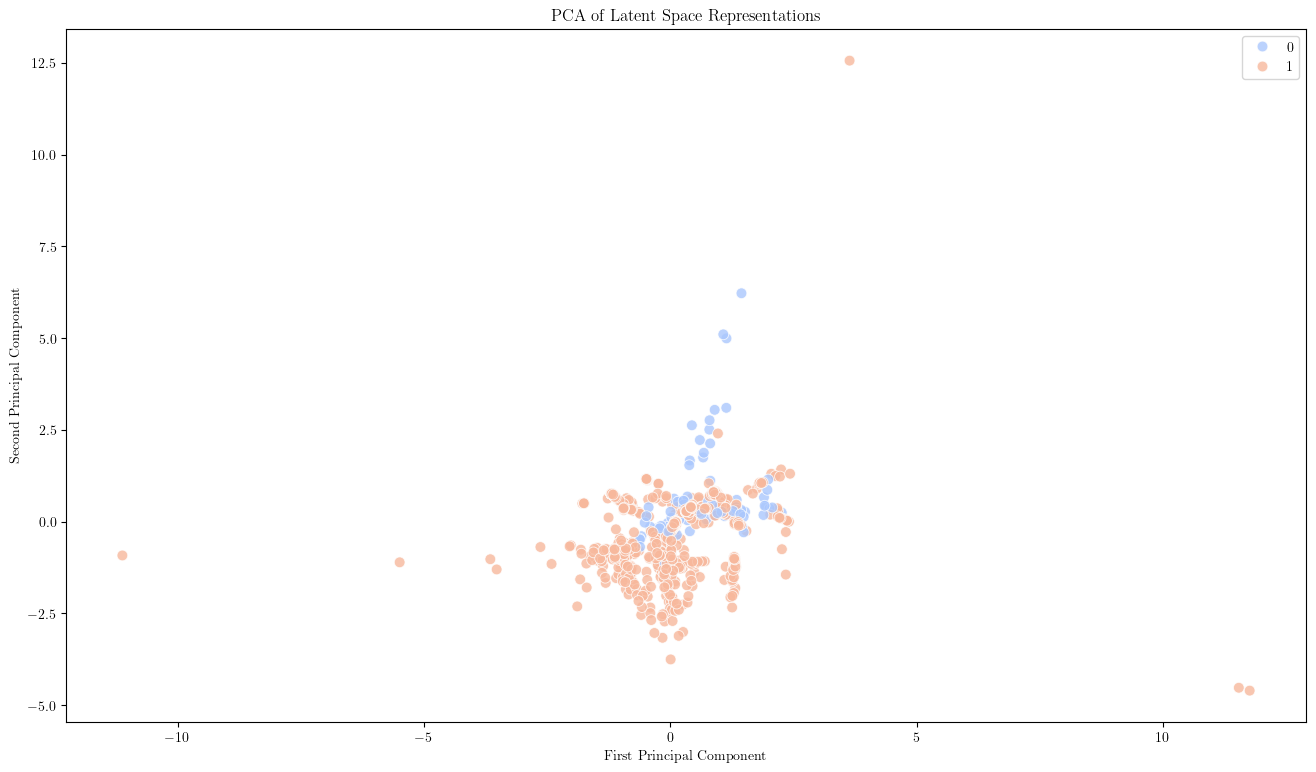

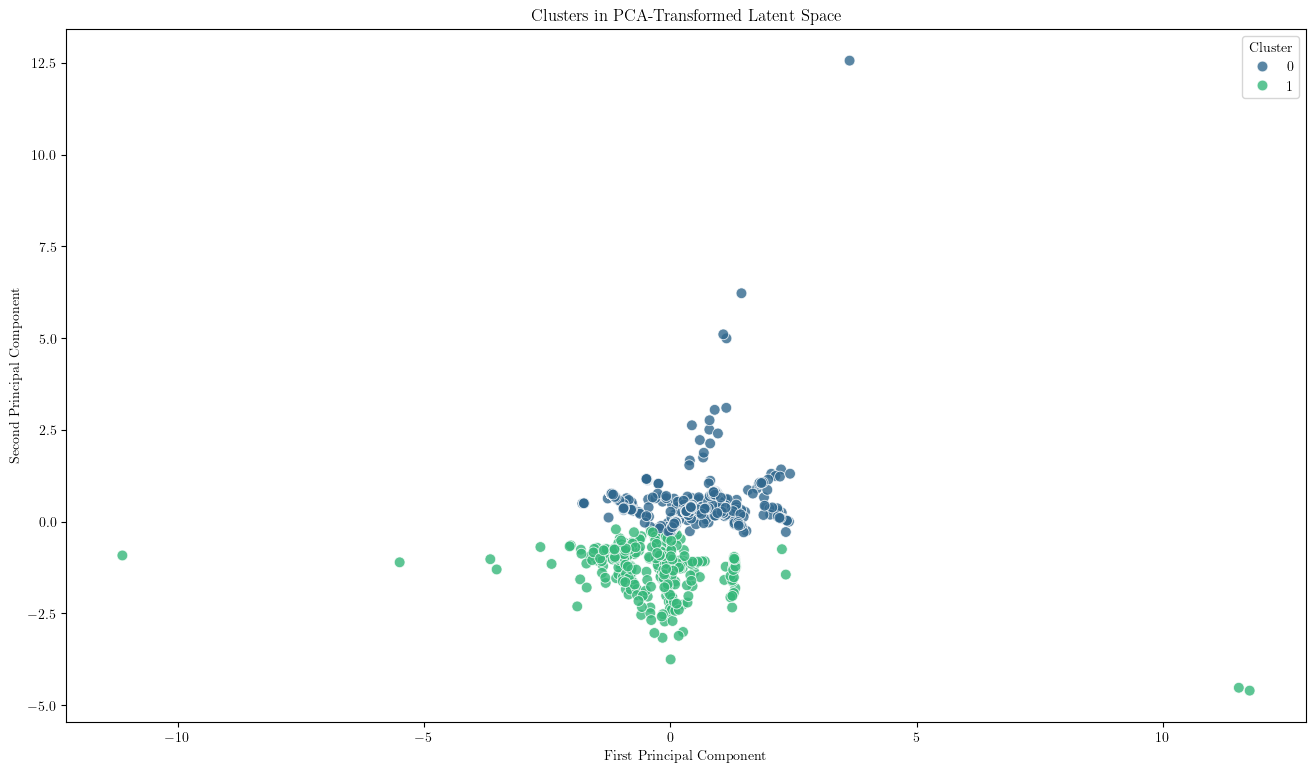

Silhouette Score: 0.4328971803188324
Adjusted Rand Index (ARI): -0.05271175344088743


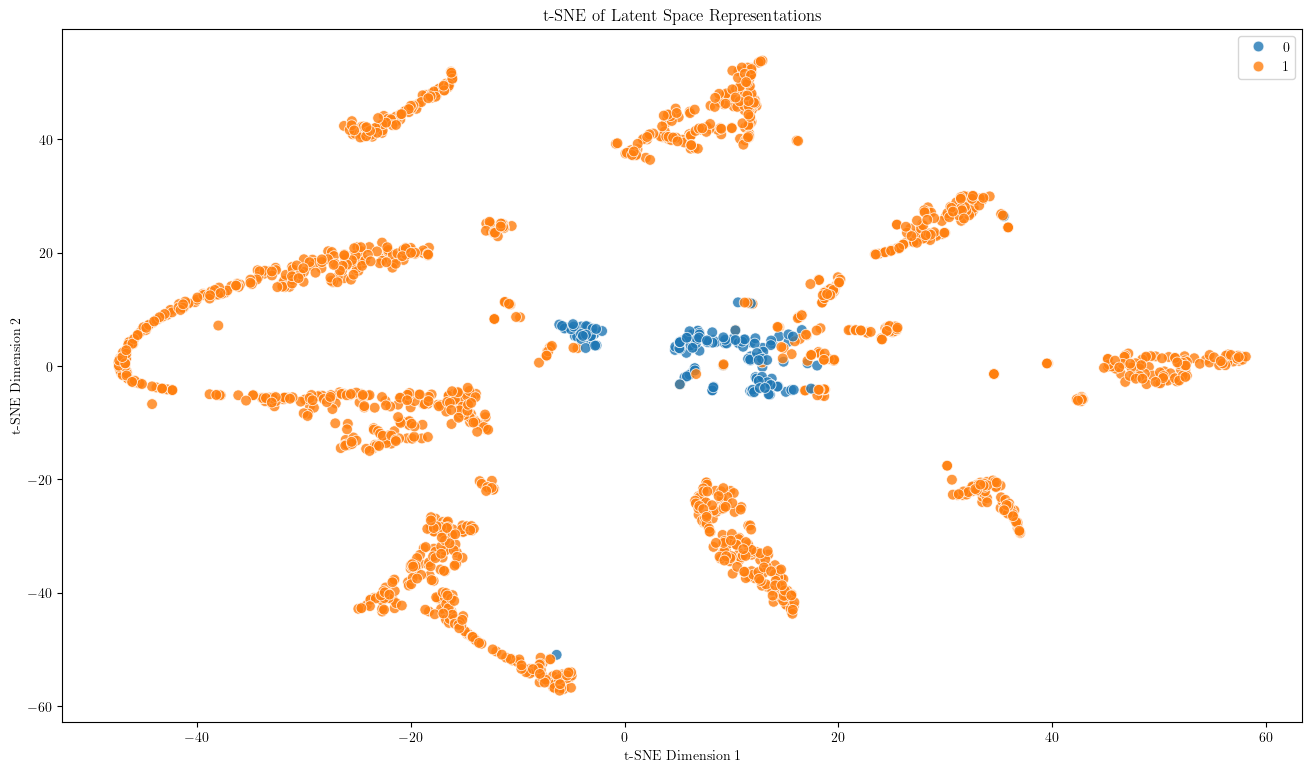

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



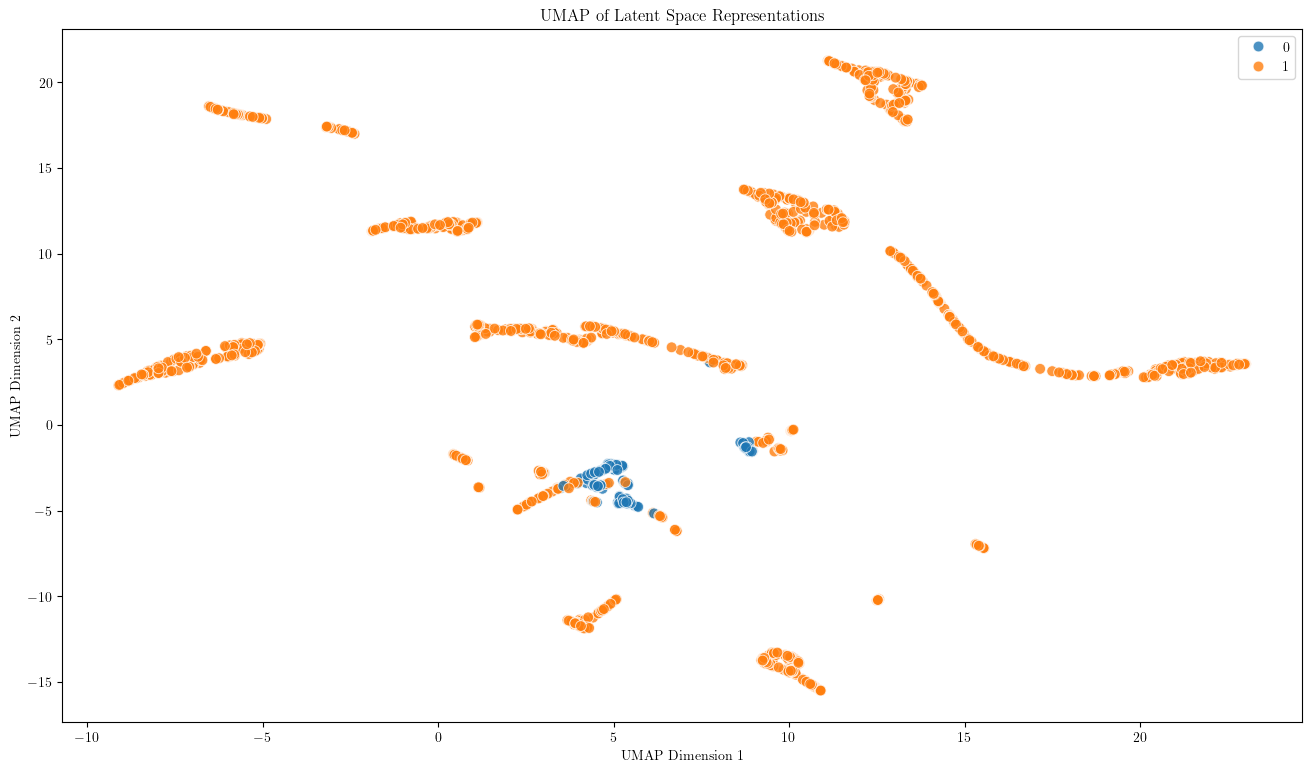

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning:

The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/si

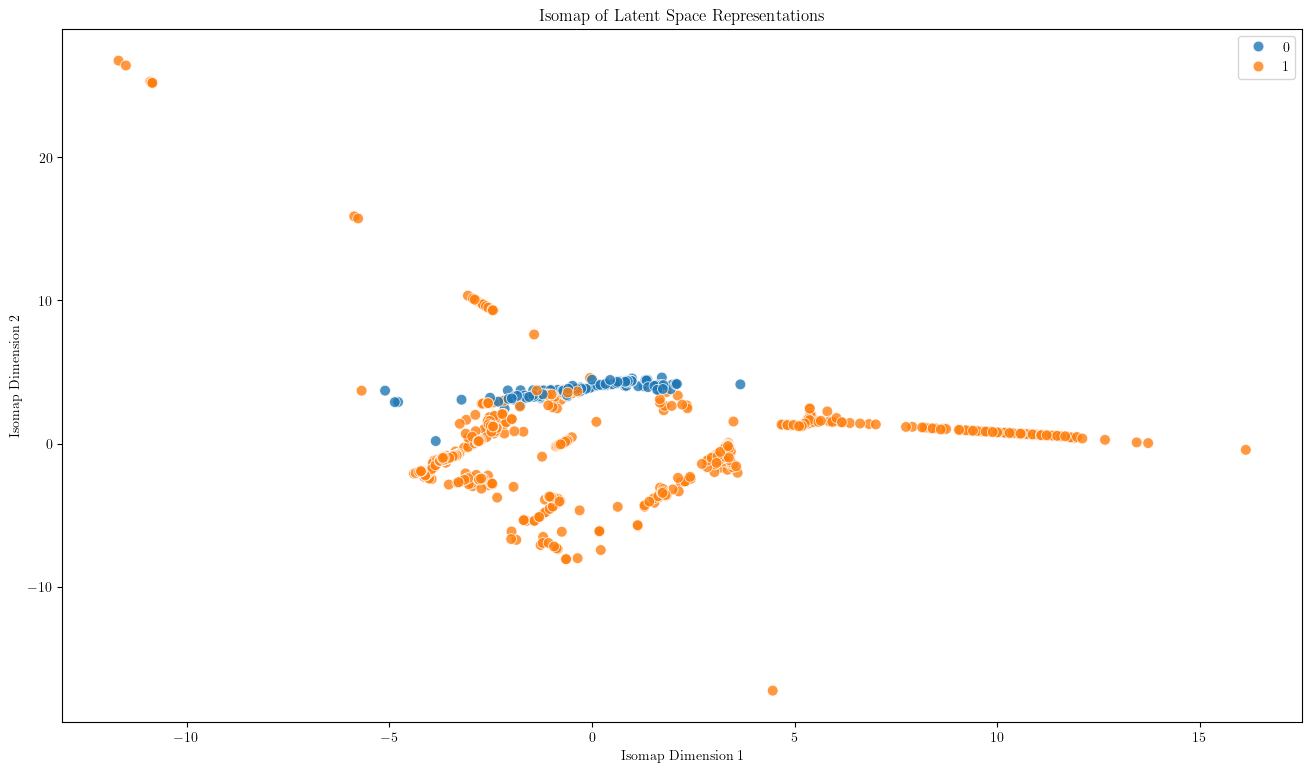

In [116]:
visualize_latent_space_pca(val_latent, val_labels_np, None, None, file_path='figs/full_dataset')
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space', file_path='figs/full_dataset')
visualize_latent_space_tsne(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_umap(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_isomap(val_latent, val_labels_np, palette='tab10', file_path='figs/full_dataset')

In [117]:
print(val_latent.shape)
print(val_labels_np.shape)
print(len(get_source_data_val_freq(20)))

(1733, 18)
(1733,)
1733


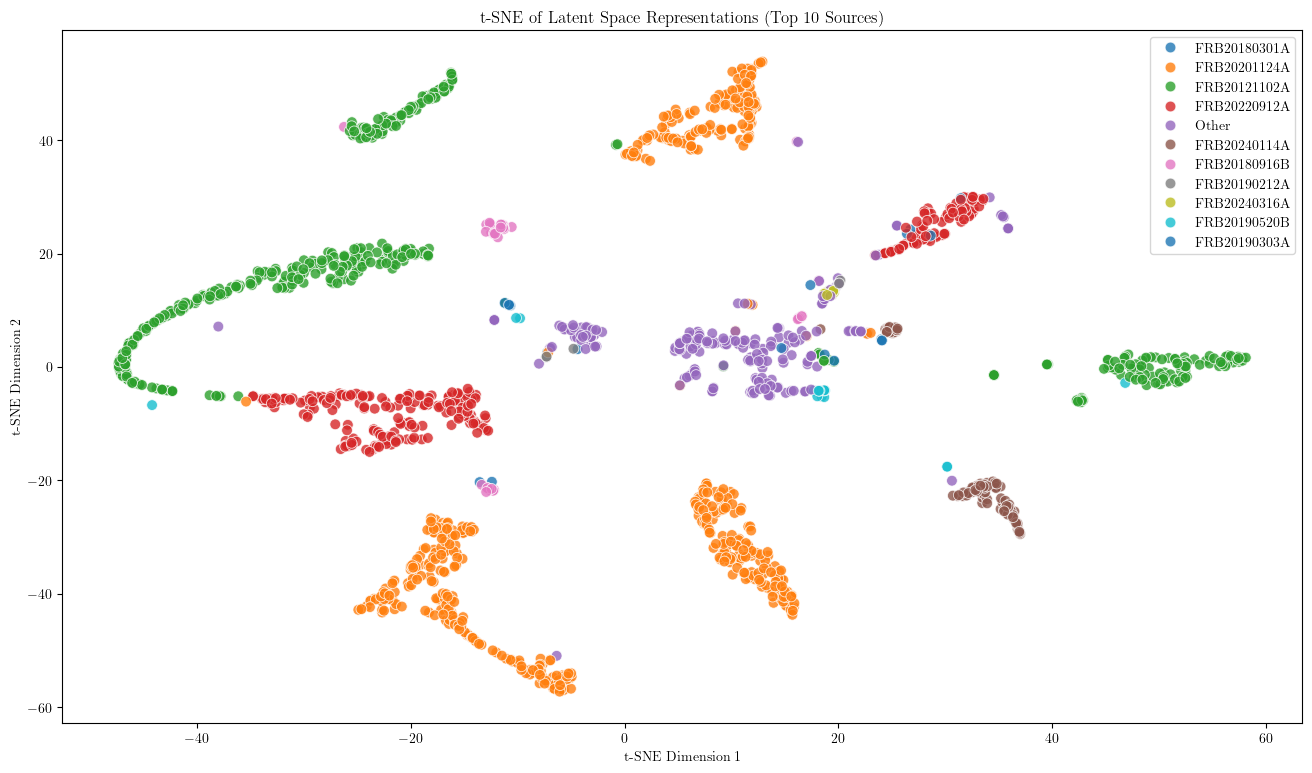

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



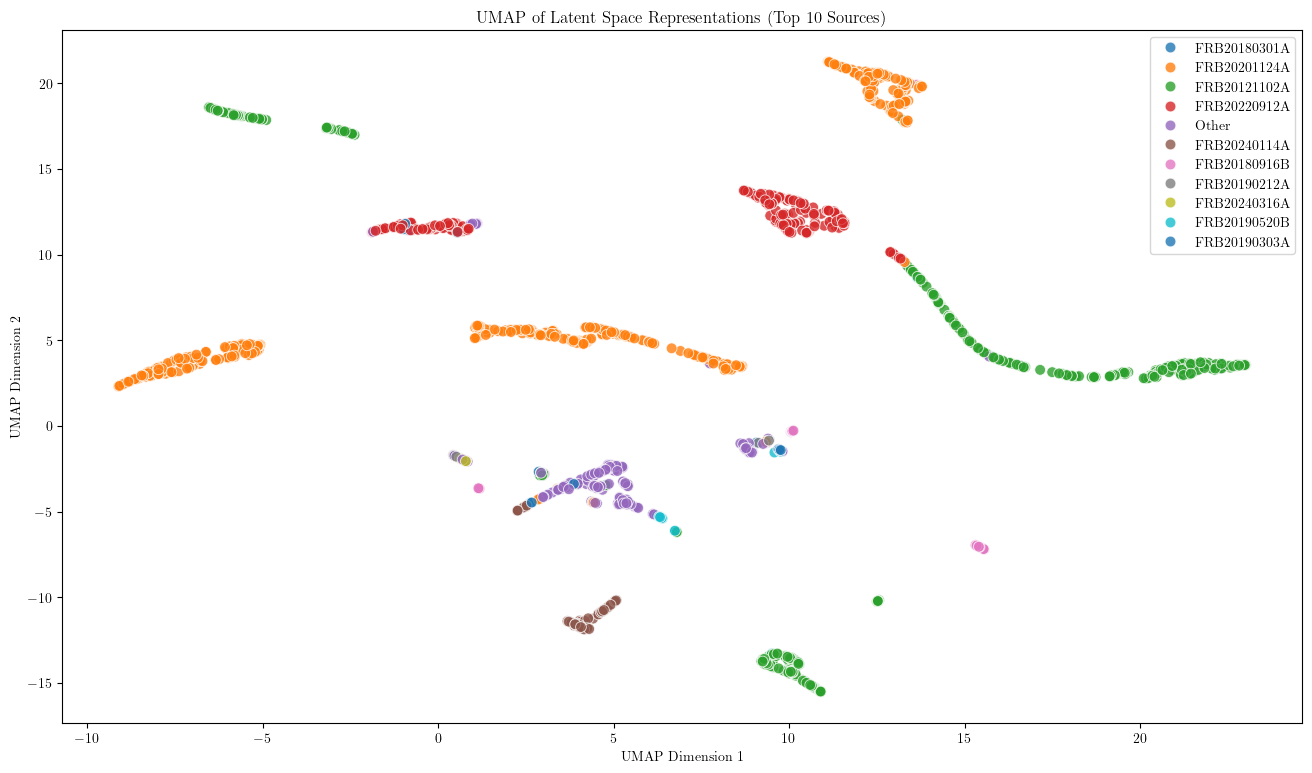

In [118]:
visualize_latent_space_tsne(val_latent, get_source_data_val_freq(10)[:], title='t-SNE of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset')
visualize_latent_space_umap(val_latent, get_source_data_val_freq(10), title='UMAP of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset')

In [119]:
def visualize_latent_space_tsne_interactive(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    tsne_df = pd.DataFrame({
        'TSNE-1': latent_2d[:, 0],
        'TSNE-2': latent_2d[:, 1],
        'Label': labels
    })

    fig = px.scatter(
        tsne_df, 
        x='TSNE-1', 
        y='TSNE-2', 
        color='Label', 
        hover_data=['Label'], 
        title='Interactive t-SNE of Latent Space Representations',
        width=800,
        height=800
    )

    fig.show()

visualize_latent_space_tsne_interactive(val_latent, get_source_data_val_freq(10))

In [120]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# Step 2: Filter the dataset to exclude these repeaters
filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
filtered_data_clean = frb_data_clean.loc[filtered_indices]
filtered_labels = labels.loc[filtered_indices]

# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)


In [121]:


# Step 7: Train the model with the filtered dataset
filtered_model_1 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

# set modle weights
filtered_model_1.load_state_dict(torch.load("model_weights_filtered_repeaters.pth", map_location=device))

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(filtered_model_1, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)



=== Final Evaluation ===
Validation Accuracy: 0.8696
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       0.94      0.81      0.87       124

    accuracy                           0.89       274
   macro avg       0.90      0.88      0.89       274
weighted avg       0.90      0.89      0.89       274

Confusion Matrix:
 [[144   6]
 [ 24 100]]



=== PCA Visualization ===


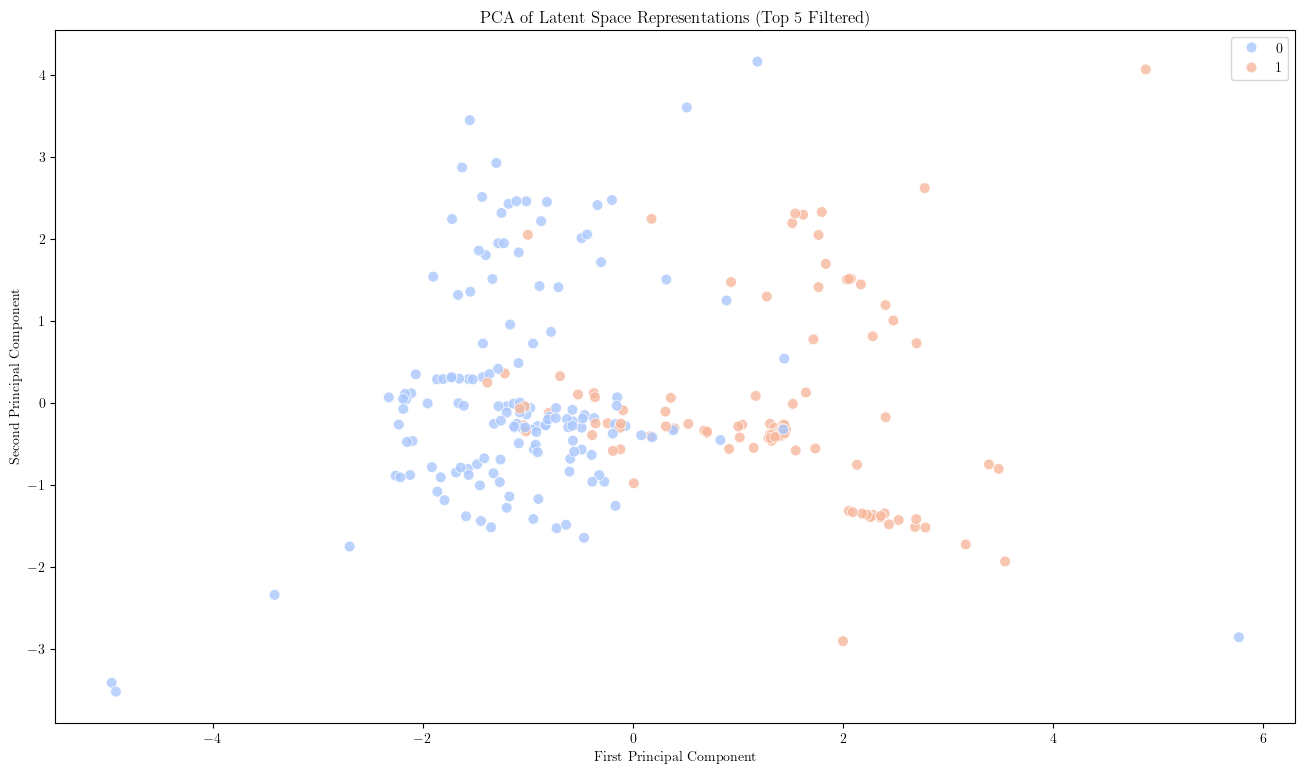


=== Clustering Analysis in Latent Space ===


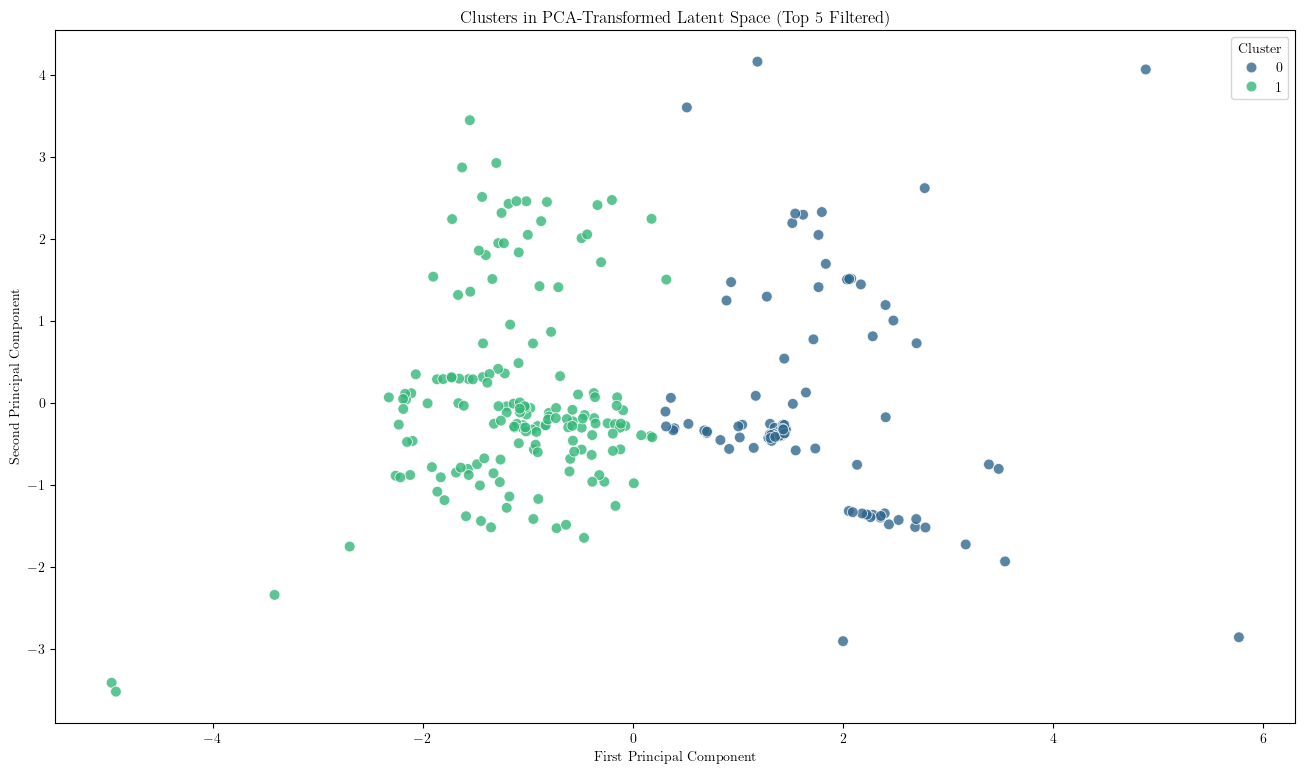

Silhouette Score: 0.48802658915519714
Adjusted Rand Index (ARI): 0.5970936997427123

=== t-SNE Visualization ===


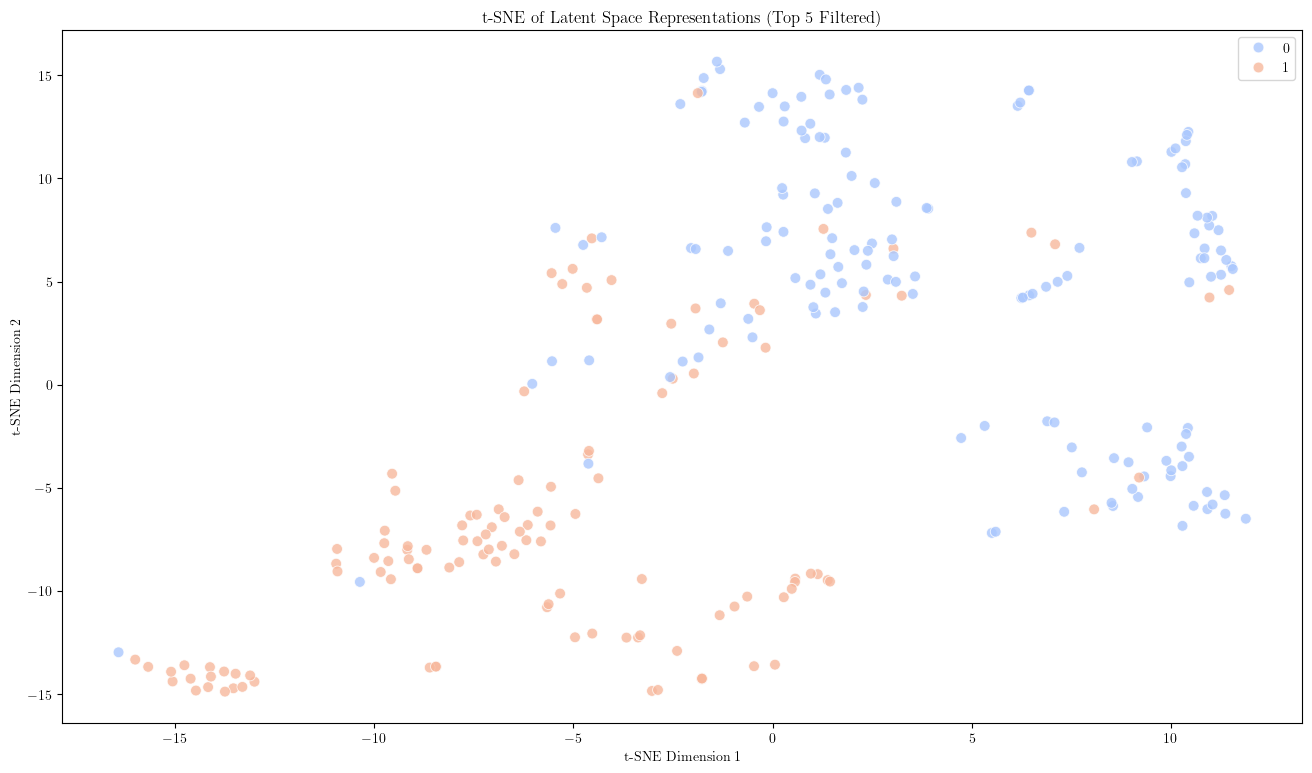


=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



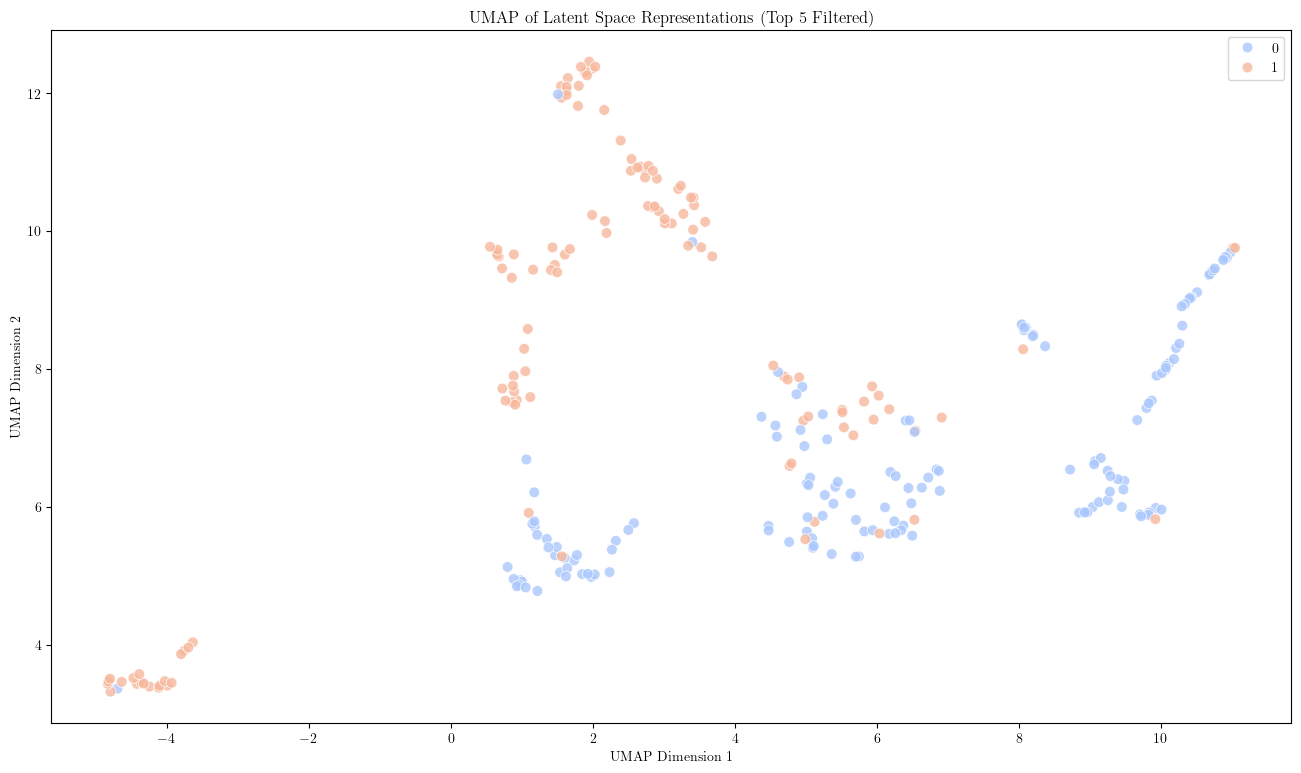


=== Isomap Visualization ===


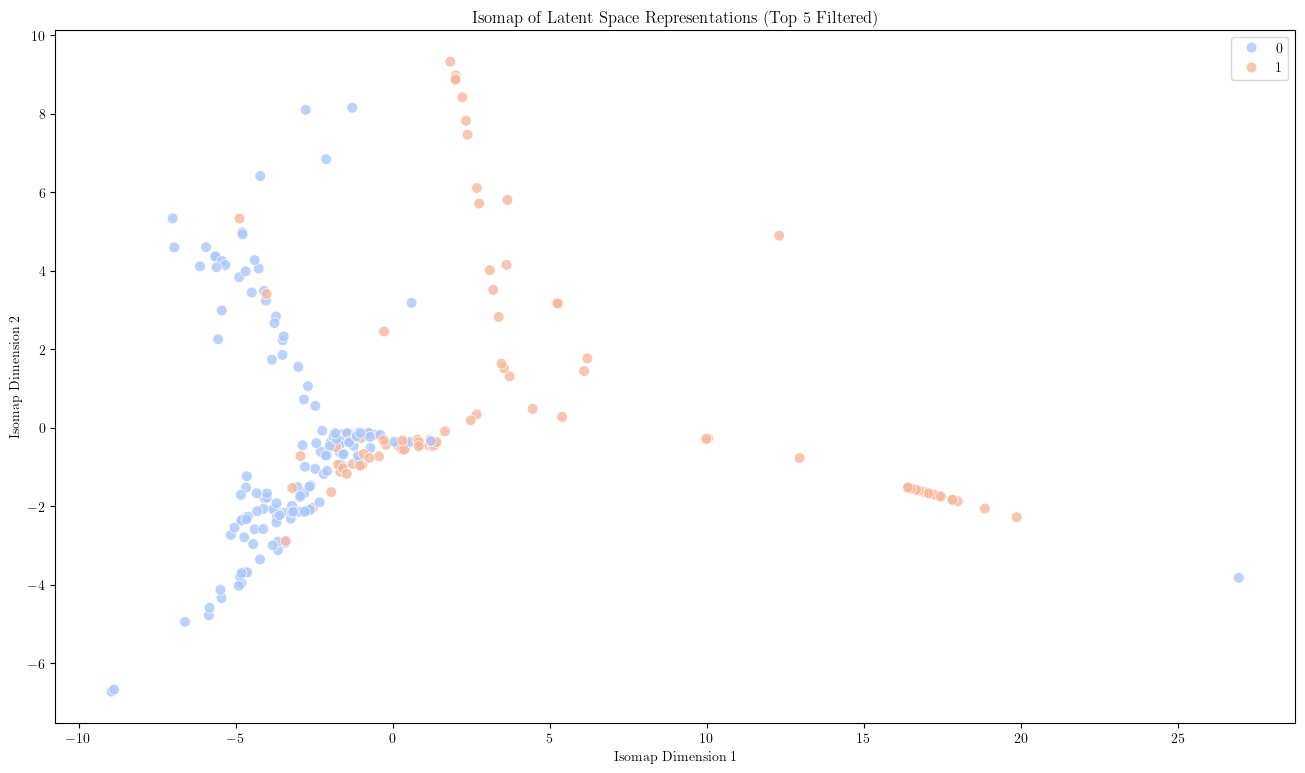

In [122]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_1, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_1, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, filtered_model_1, device, title='PCA of Latent Space Representations (Top 5 Filtered)', file_path='figs/filtered_repeaters')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Top 5 Filtered)', file_path='figs/filtered_repeaters')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Top 5 Filtered)', palette='coolwarm', file_path='figs/filtered_repeaters')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Top 5 Filtered)', palette='coolwarm', file_path='figs/filtered_repeaters')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Top 5 Filtered)', palette='coolwarm', file_path='figs/filtered_repeaters')


In [123]:
# Step 1: Remove all repeaters from the dataset
non_repeater_indices = frb_data[frb_data['Repeater'] == 0].index
no_repeater_data_clean = frb_data_clean.loc[non_repeater_indices]
no_repeater_labels = labels.loc[non_repeater_indices]

# Step 2: Standardize the no_repeater dataset
scaler = StandardScaler()
no_repeater_data_scaled = scaler.fit_transform(no_repeater_data_clean)

# Step 3: Split the no_repeater dataset into train and validation sets
train_data_no_repeater, val_data_no_repeater, train_labels_no_repeater, val_labels_no_repeater = train_test_split(
    no_repeater_data_scaled, no_repeater_labels, test_size=0.2, random_state=42, stratify=no_repeater_labels
)

# Step 4: Convert to PyTorch tensors
train_tensor_no_repeater = torch.tensor(train_data_no_repeater, dtype=torch.float32)
val_tensor_no_repeater = torch.tensor(val_data_no_repeater, dtype=torch.float32)
train_labels_tensor_no_repeater = torch.tensor(train_labels_no_repeater.values, dtype=torch.long)
val_labels_tensor_no_repeater = torch.tensor(val_labels_no_repeater.values, dtype=torch.long)

# Step 5: Create datasets and dataloaders
batch_size = 64
train_dataset_no_repeater = TensorDataset(train_tensor_no_repeater, train_labels_tensor_no_repeater)
val_dataset_no_repeater = TensorDataset(val_tensor_no_repeater, val_labels_tensor_no_repeater)

train_loader_no_repeater = DataLoader(train_dataset_no_repeater, batch_size=batch_size, shuffle=True)
val_loader_no_repeater = DataLoader(val_dataset_no_repeater, batch_size=batch_size, shuffle=False)

# Step 7: Train the model with the no_repeater dataset
filtered_model_2 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

filtered_model_2.load_state_dict(torch.load("best_model_no_repeaters.pth", map_location=device))

def evaluate_classifier_full_oneclass(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    # f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    # class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return conf_matrix, all_preds, all_labels

# Evaluate the model after training

conf_mat_no_repeaters, _, _ = evaluate_classifier_full_oneclass(filtered_model_2, val_loader_no_repeater, device)

conf_mat_no_repeaters

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



array([[150]])


=== PCA Visualization ===


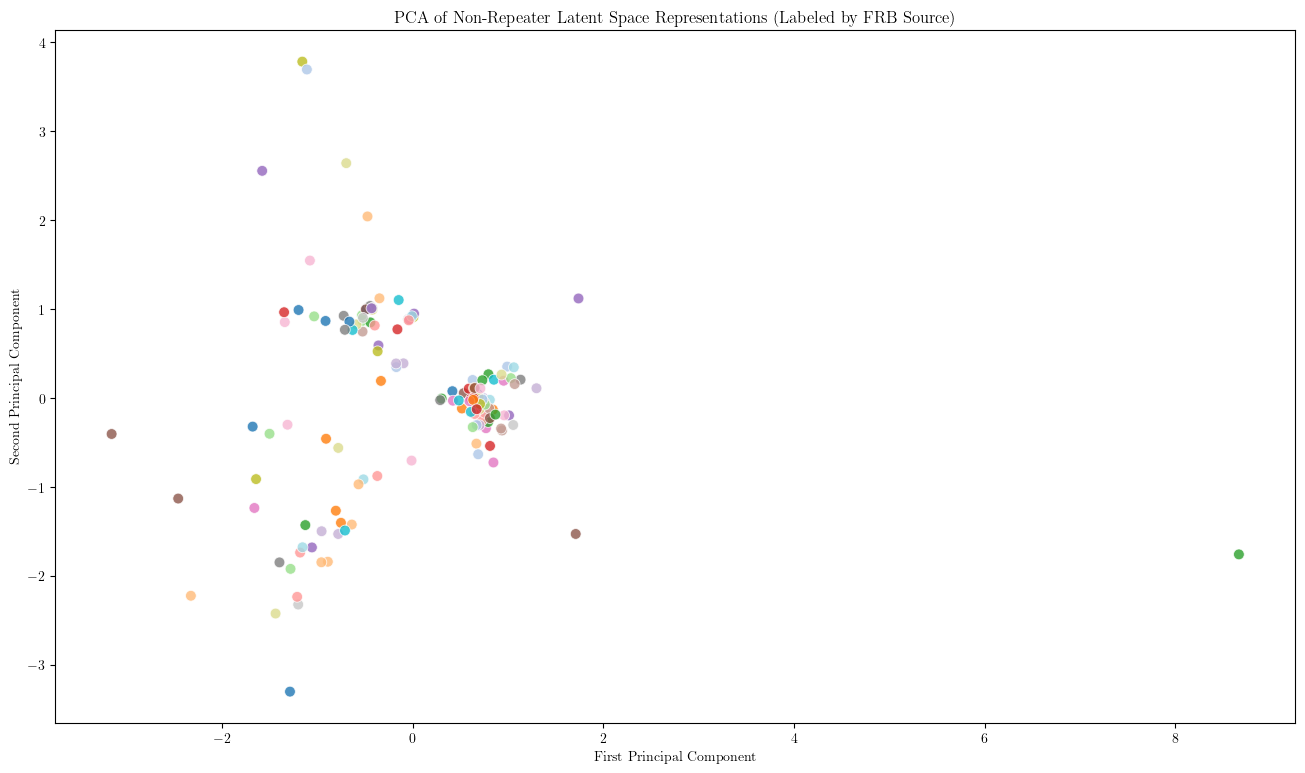


=== t-SNE Visualization ===


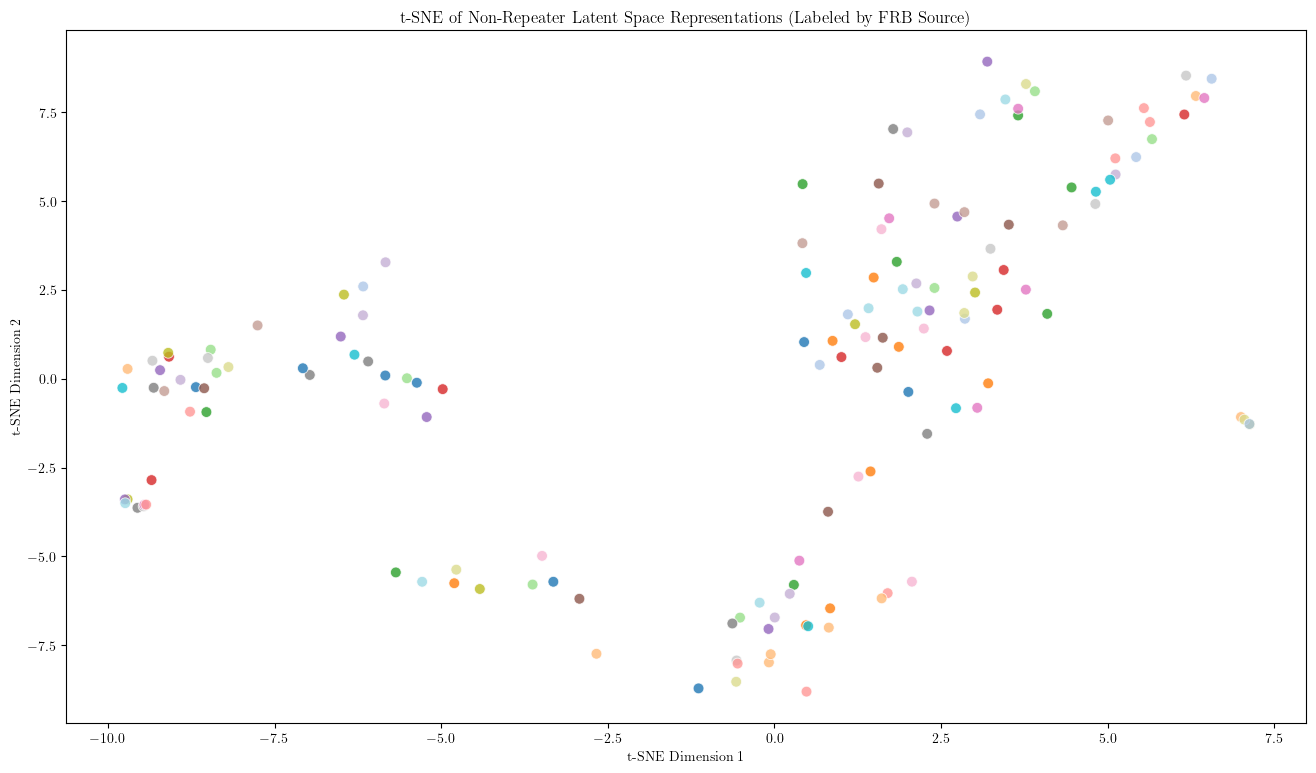


=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



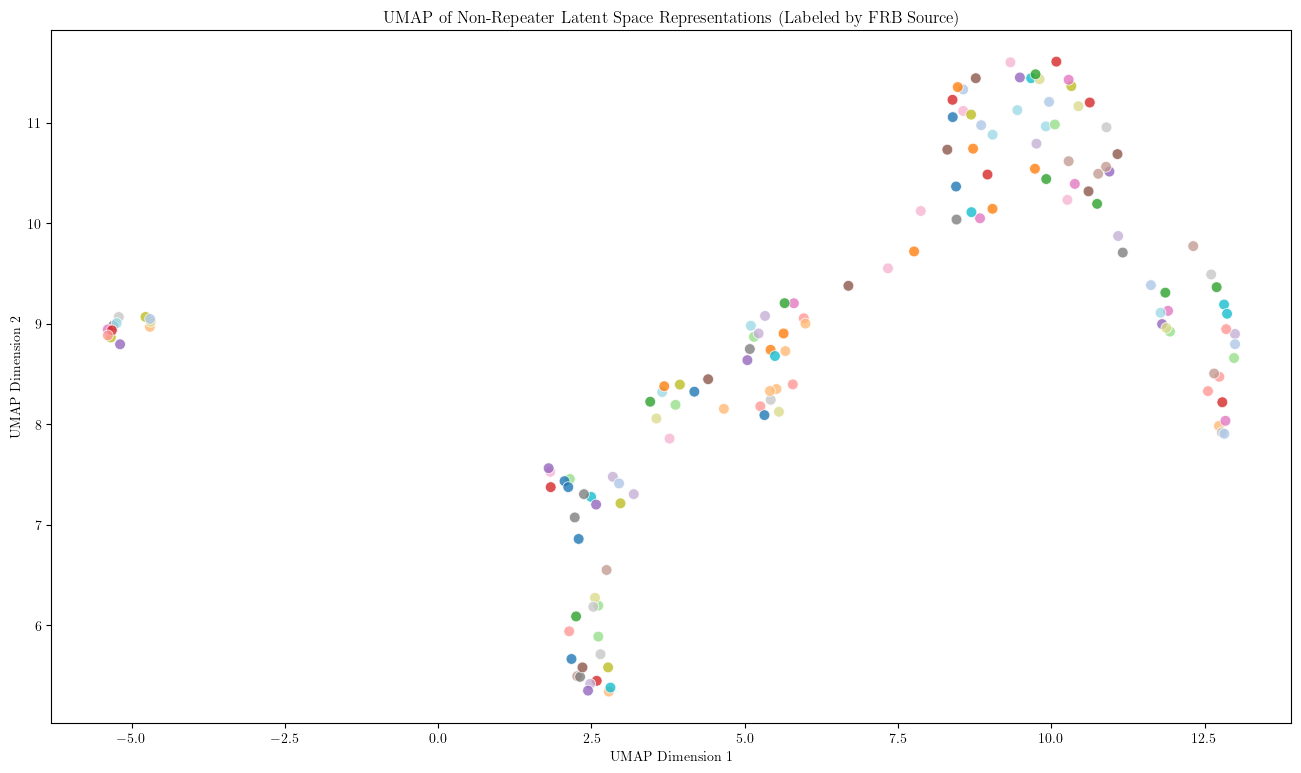

In [124]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_2, train_loader_no_repeater, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_2, val_loader_no_repeater, device)


def visualize_latent_space_pca_source_nolegend(latent_representations, sources, file_path='figs'):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('PCA of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig(join(file_path, 'PCA of Latent Space Representations (Labeled by FRB Source).svg'.replace(" ", "_")), dpi=500, format='svg')
    plt.show()
    
def visualize_latent_space_tsne_nolegend(latent_representations, sources, file_path='figs'):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('t-SNE of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig(join(file_path, 't-SNE of Latent Space Representations (Labeled by FRB Source).svg'.replace(" ", "_")), dpi=500, format='svg')
    plt.show()
    
def visualize_latent_space_umap_source_nolegend(latent_representations, sources, file_path='figs'):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)

    plt.figure(figsize=(16, 9))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('UMAP of Non-Repeater Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig(join(file_path, 'UMAP of Latent Space Representations (Labeled by FRB Source).svg'.replace(" ", "_")), dpi=500, format='svg')
    plt.show()


# Extract the source names for the validation set
val_sources_no_repeater = original_data.loc[val_labels_no_repeater.index, "Source"].values


# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca_source_nolegend(val_latent, val_sources_no_repeater, file_path='figs/no_repeaters')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne_nolegend(val_latent, val_sources_no_repeater, file_path='figs/no_repeaters')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap_source_nolegend(val_latent, val_sources_no_repeater, file_path='figs/no_repeaters')


In [125]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(val_latent)  # val_latent from no_repeater data

# Here we use KMeans with 3 clusters as an example
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embedding)

# plot clusters
plt.figure(figsize=(16, 9))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Clusters in UMAP-Transformed Latent Space Using KMeans')
plt.savefig(join('figs/no_repeaters', 'Clusters in UMAP-Transformed Latent Space Using KMeans.svg'.replace(" ", "_")), dpi=500, format='svg')

val_indices_no_repeater = val_labels_no_repeater.index
df_val_original = original_data.loc[val_indices_no_repeater].copy()
df_val_original['UMAP_cluster'] = cluster_labels

# Display a preview of the dataframe
df_val_original.head() 

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Dynamic Spectral  PulseID  \
3173  https://fastzjlab-imgs.alkaidos.cn/img/plain/b...     3571   
3408  https://fastzjlab-imgs.alkaidos.cn/img/plain/b...     3642   
3401  https://fastzjlab-imgs.alkaidos.cn/img/plain/b...     3620   
5313  https://fastzjlab-imgs.alkaidos.cn/img/plain/b...     5574   
3223  https://fastzjlab-imgs.alkaidos.cn/img/plain/b...     3443   

            Source Telescope  Date  Repeater Receiver Observing_band  \
3173  FRB20190517C     CHIME   NaN       0.0      NaN        400-800   
3408  FRB20190625C     CHIME   NaN       0.0      NaN        400-800   
3401  FRB20190614B     CHIME   NaN       0.0      NaN        400-800   
5313  FRB20000925A    Parkes   NaN       0.0  13 beam      1230-1518   
3223  FRB20190224A     CHIME   NaN       0.0      NaN        400-800   

               MJD        GL  ...  RM_syn  RM_syn_err  RM_QUfit RM_QUfit_err  \
3173  58620.921231  182.4800  ...     NaN         NaN       NaN          NaN   
3408  58659.775190  188.2000  ...     NaN         NaN       NaN          NaN   
3401  58648.528685   82.6500  ...     NaN         NaN       NaN          NaN   
5313  51812.769565  281.0488  ...     NaN         NaN       NaN          NaN   
3223  58538.095049  128.2200  ...     NaN         NaN       NaN          NaN   

      Scatt_t    Scatt_t_err Scin_f Scin_f_err  \
3173    0.149  +0.012/-0.012    NaN        NaN   
3408    <0.63            NaN    NaN        NaN   
3401    <0.68            NaN    NaN        NaN   
5313      NaN            NaN    NaN        NaN   
3223     5.77    +0.75/-0.75    NaN        NaN   

                                   Reference UMAP_cluster  
3173        https://www.chime-frb.ca/catalog            2  
3408        https://www.chime-frb.ca/catalog            2  
3401        https://www.chime-frb.ca/catalog            2  
5313  https://doi.org/10.1093/mnras/stab2275            1  
3223        https://www.chime-frb.ca/catalog            2  

[5 rows x 41 columns]

In [126]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=df_val_original["Telescope"], palette='viridis', s=60, alpha=0.8)
plt.title('Clusters in UMAP-Transformed Latent Space (Labeled by Telescope)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig(join('figs/no_repeaters', 'UMAP-Transformed Latent Space (Labeled by Telescope).svg'.replace(" ", "_")), dpi=500, format='svg')


=== Final Evaluation ===
Validation Accuracy: 0.8855
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.89      0.90       150
    Repeater       0.87      0.90      0.89       129

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279

Confusion Matrix:
 [[133  17]
 [ 13 116]]

=== PCA Visualization ===


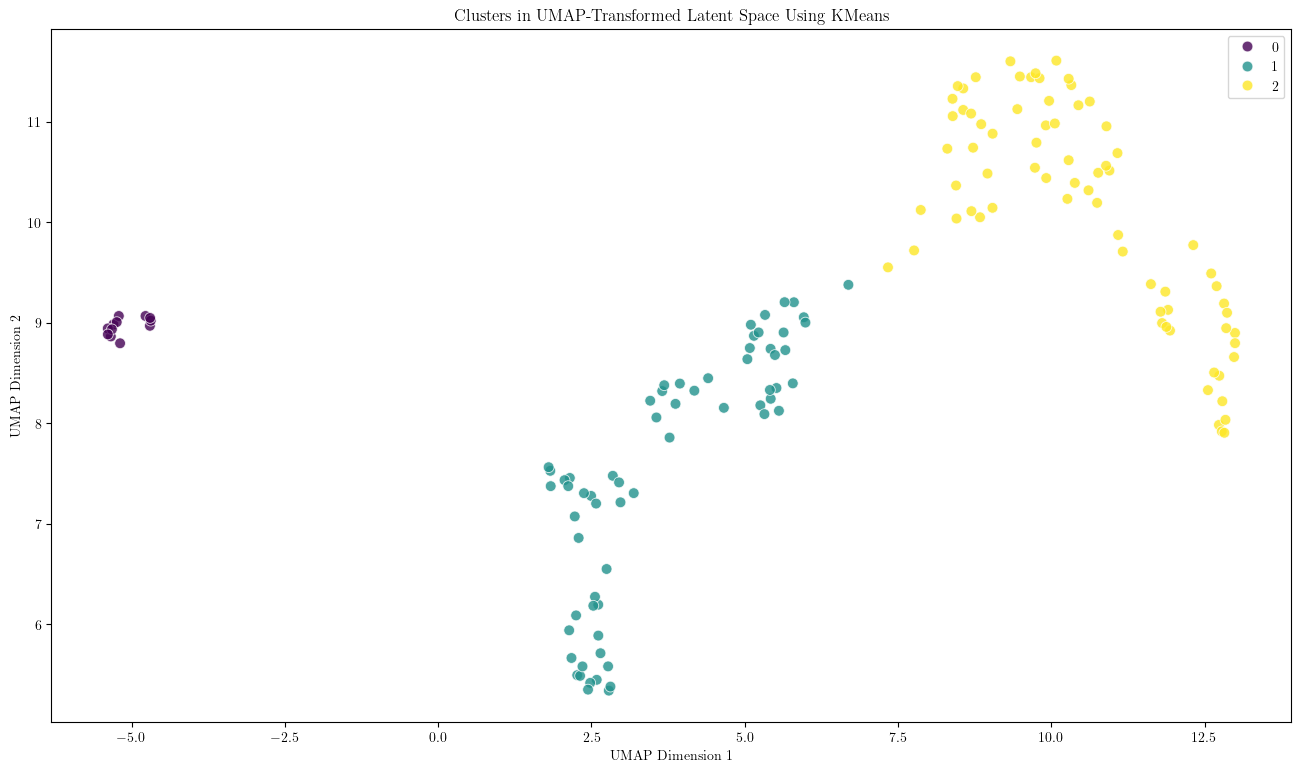

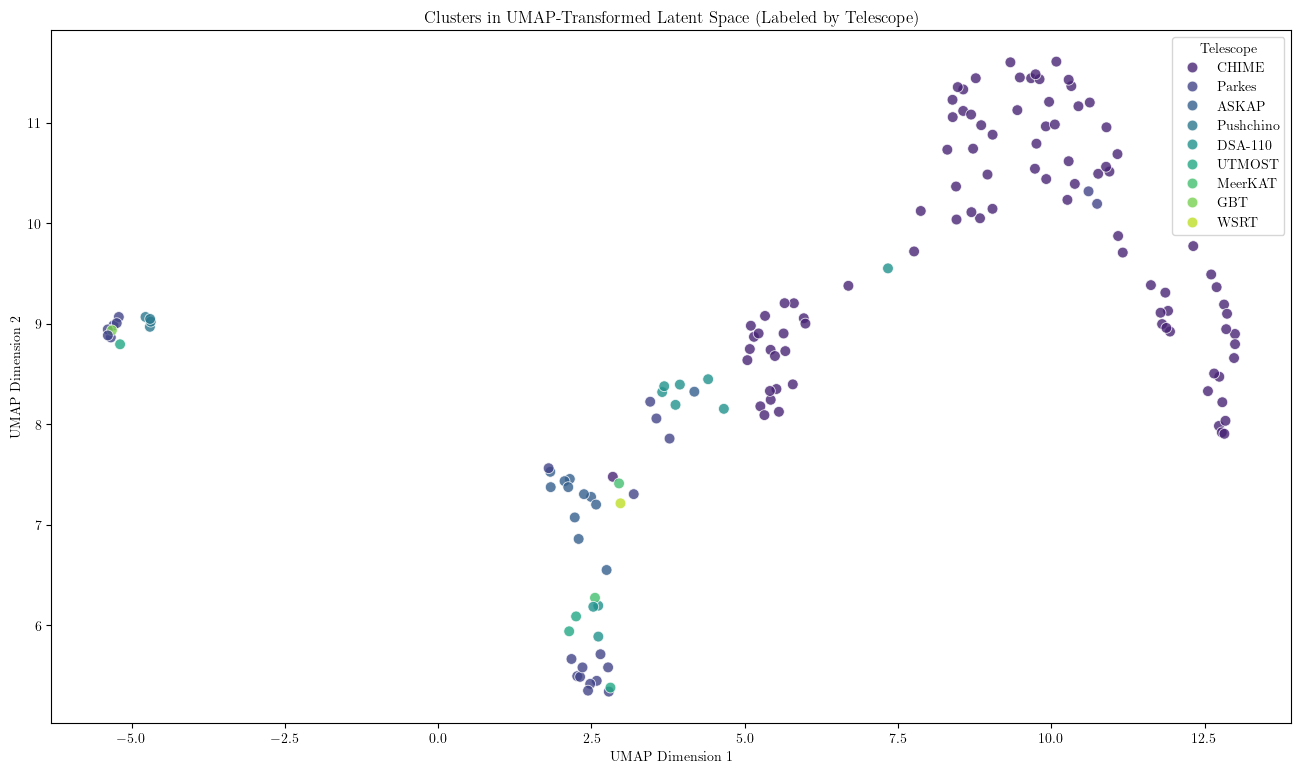

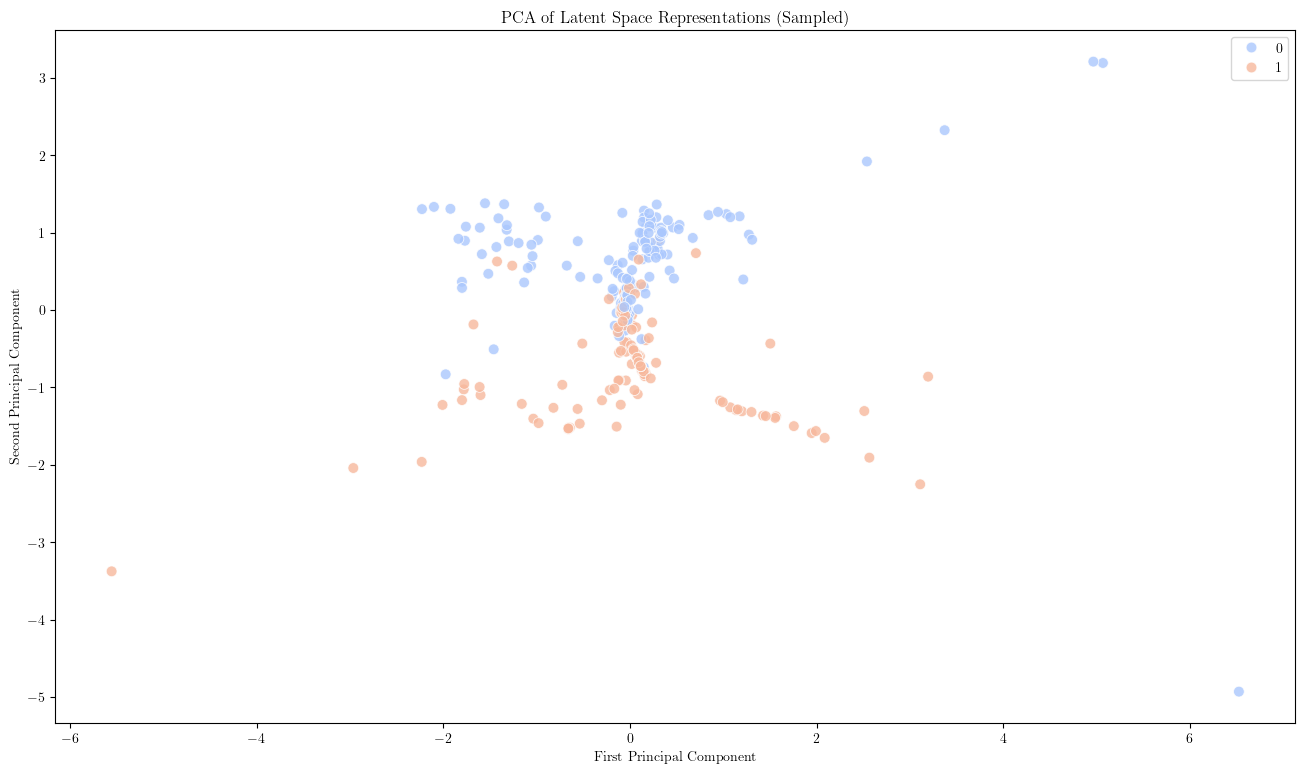


=== Clustering Analysis in Latent Space ===


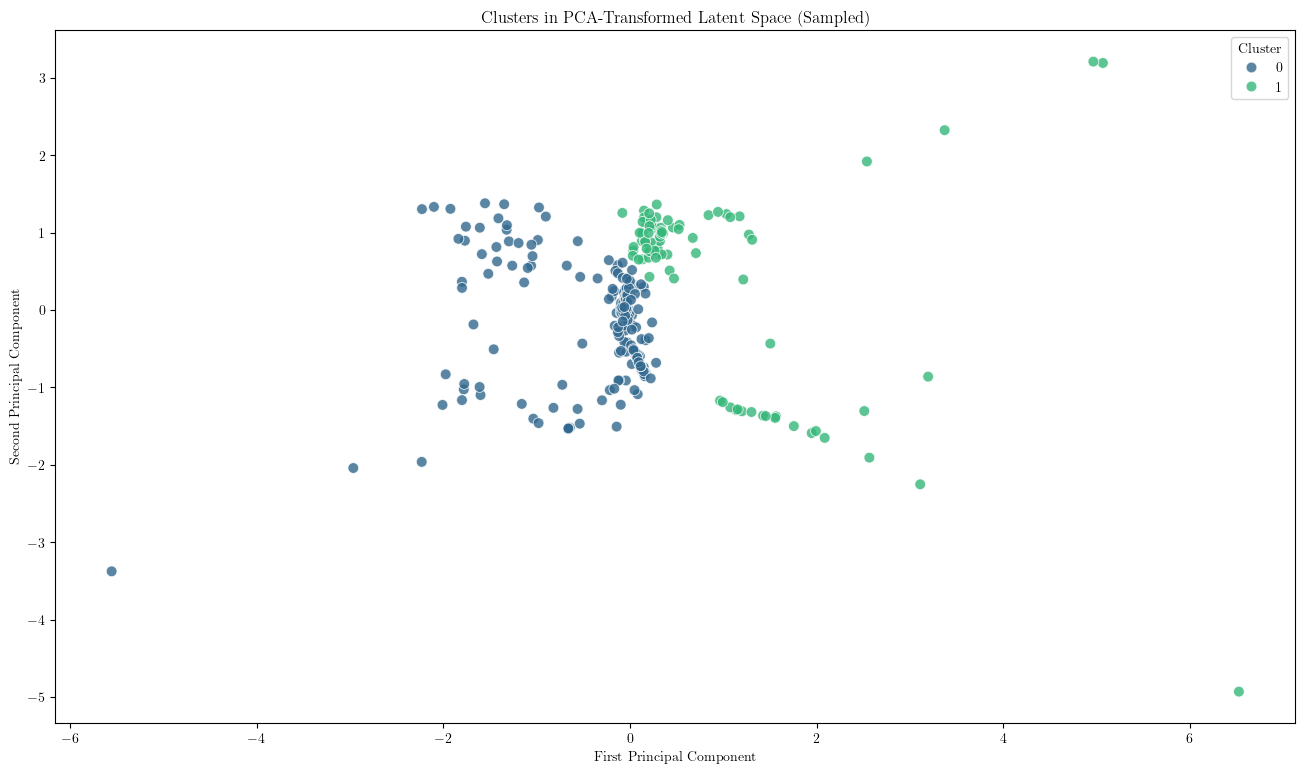

Silhouette Score: 0.3346211612224579
Adjusted Rand Index (ARI): 0.0441007861583154

=== t-SNE Visualization ===


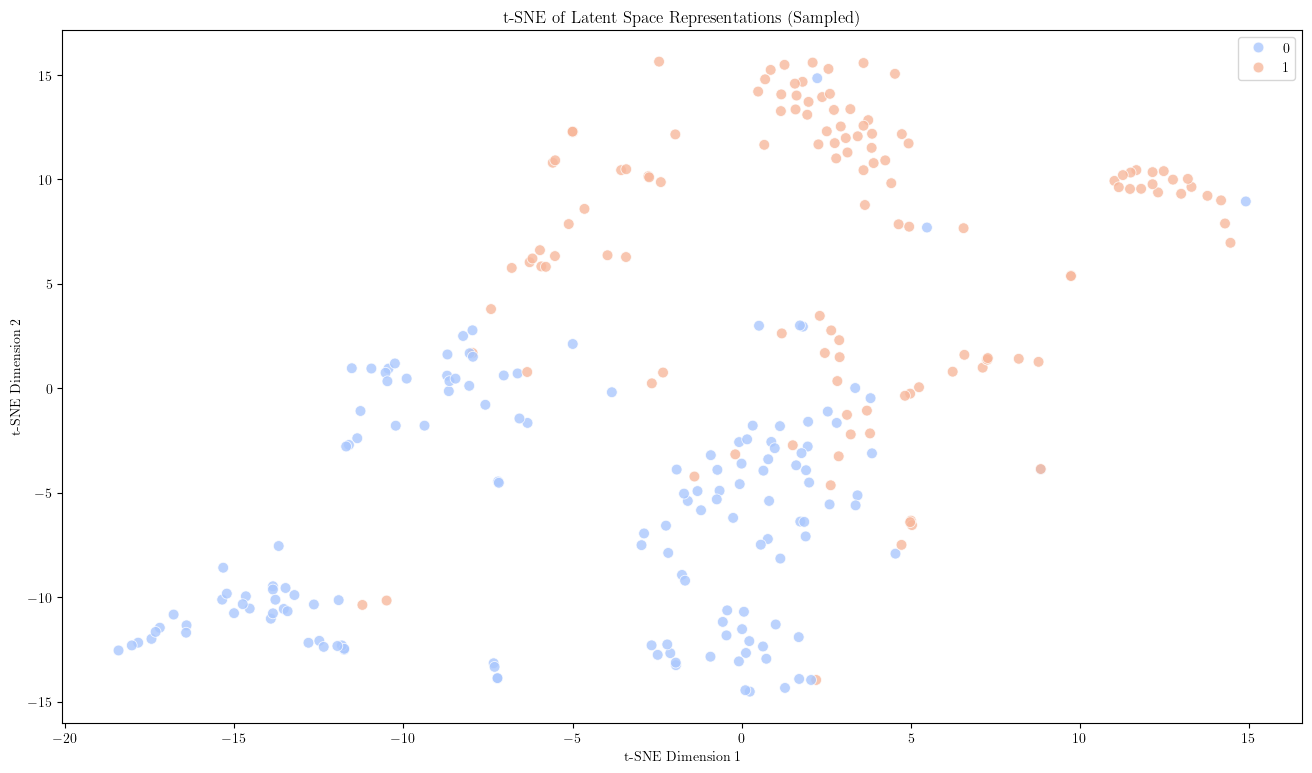


=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



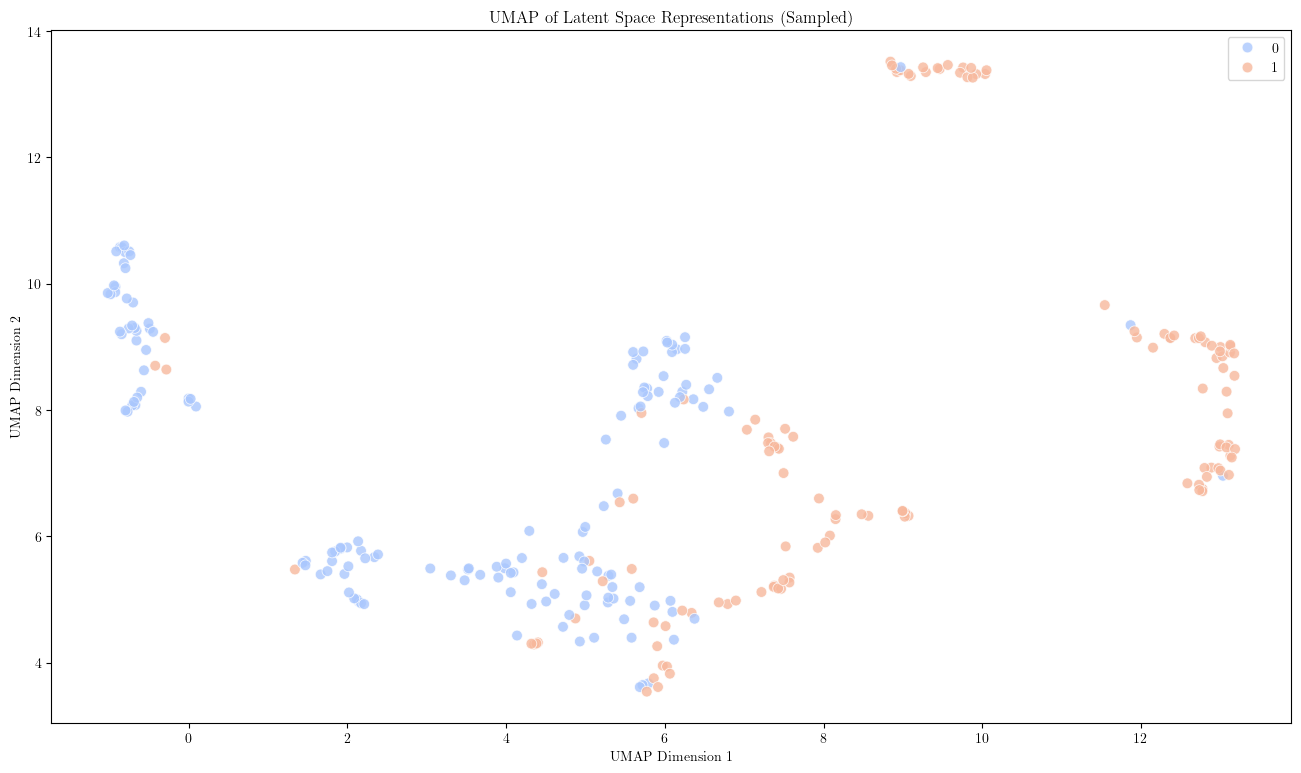


=== Isomap Visualization ===


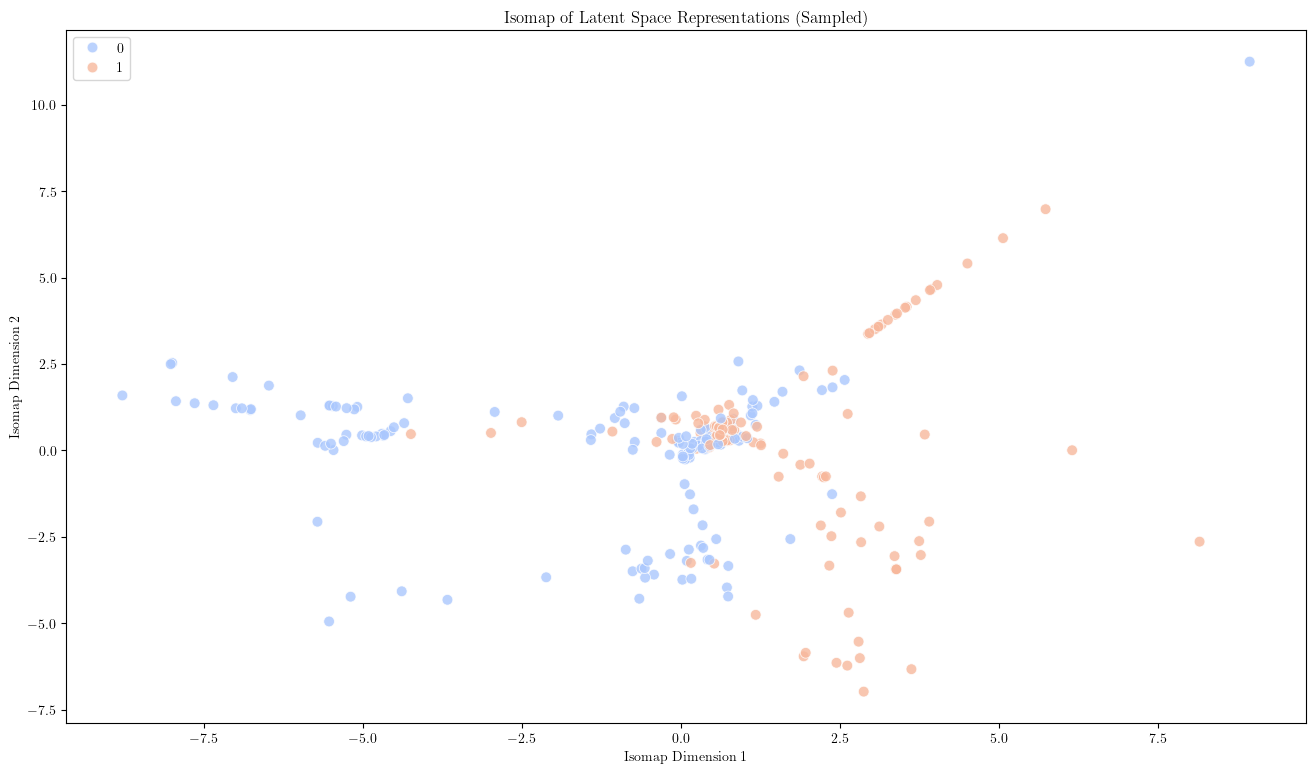

In [127]:
#import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# # Step 2: Filter the dataset to exclude these repeaters
# filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
# filtered_data_clean = frb_data_clean.loc[filtered_indices]
# filtered_labels = labels.loc[filtered_indices]

top_5_repeaters = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts().head(5).index.tolist()

# Sample 10 signals from each top repeater
sampled_indices = []
for repeater in top_5_repeaters:
    repeater_indices = frb_data[frb_data['Source'] == repeater].index
    sampled = np.random.choice(repeater_indices, size=min(5, len(repeater_indices)), replace=False)
    sampled_indices.extend(sampled)

# Get all other indices excluding the top 5 repeaters
non_top5_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index

# Combine the sampled top5 and the rest
final_indices = np.concatenate([non_top5_indices, sampled_indices])

# Filter the clean data and labels accordingly
filtered_data_clean = frb_data_clean.loc[final_indices]
filtered_labels = labels.loc[final_indices]


# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)


# Step 7: Train the model with the filtered dataset
filtered_model_3 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

filtered_model_3.load_state_dict(torch.load("filtered_model_sampled.pth", map_location=device))


# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(filtered_model_3, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_3, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(filtered_model_3, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, filtered_model_3, device, title='PCA of Latent Space Representations (Sampled)', file_path='figs/filtered_repeaters_sampled')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Sampled)', file_path='figs/filtered_repeaters_sampled')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Sampled)', palette='coolwarm', file_path='figs/filtered_repeaters_sampled')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Sampled)', palette='coolwarm', file_path='figs/filtered_repeaters_sampled')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Sampled)',palette='coolwarm', file_path='figs/filtered_repeaters_sampled')

FRB20190112A is similar to FRB20191106C with a score of 1.08677 (Repeater difference)
FRB20190112A is similar to FRB20190915D with a score of 0.85018 (Repeater difference)


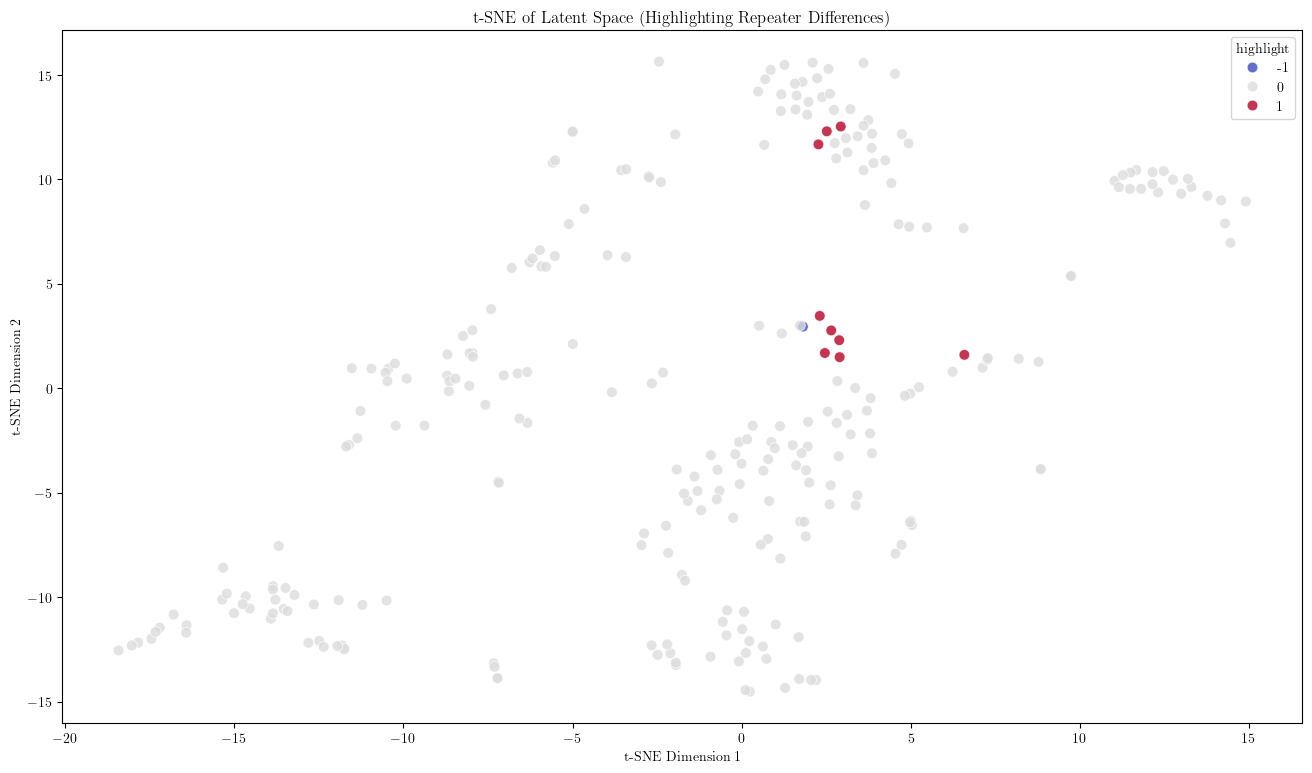

In [128]:
val_index = val_labels_filtered.index
val_sources = original_data.loc[val_index, 'Source'].values

latent_df = pd.DataFrame(val_latent, index=val_index)
latent_df['Source'] = val_sources

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(val_latent)
distances, indices = nbrs.kneighbors(val_latent)

# Simple nearest neighbor lookup (no cluster checks)
def find_similar(source):
    idx = latent_df[latent_df['Source'] == source].index[0]
    pos = list(latent_df.index).index(idx)

    neighbors = {}
    for i, neighbor_pos in enumerate(indices[pos][1:]):  # skip self (first neighbor)
        neighbor_idx = latent_df.index[neighbor_pos]
        neighbors[latent_df.loc[neighbor_idx, 'Source']] = float(distances[pos][i+1])
    return neighbors

# Track pairs where a non-repeater is similar to a repeater
highlight_non_repeaters = set()
highlight_repeaters = set()

for source in all_false_positives:
    if source in garcia_list and source in zhu_ge_list and source in luo_list and source in latent_df['Source'].values:
        similar_source_data = find_similar(source)
        if similar_source_data:
            for similar_source, score in similar_source_data.items():
                source_repeater = frb_data[frb_data['Source'] == source]['Repeater'].values[0]
                neighbor_repeater = frb_data[frb_data['Source'] == similar_source]['Repeater'].values[0]

                if source_repeater != neighbor_repeater:
                    print(f"{source} is similar to {similar_source} with a score of {score:.5f} (Repeater difference)")
                    if source_repeater == 0:
                        highlight_non_repeaters.add(source)
                        highlight_repeaters.add(similar_source)
                    else:
                        highlight_non_repeaters.add(similar_source)
                        highlight_repeaters.add(source)

# Now create a color array for visualization
# 0 = normal, 1 = non-repeater flagged, 2 = repeater flagged
colors = []
for source in latent_df['Source']:
    if source in highlight_non_repeaters:
        colors.append(-1)
    elif source in highlight_repeaters:
        colors.append(1)
    else:
        colors.append(0)

latent_df['highlight'] = colors

# Updated visualization call
visualize_latent_space_tsne(val_latent, latent_df['highlight'], title='t-SNE of Latent Space (Highlighting Repeater Differences)', palette='coolwarm', file_path='figs/filtered_repeaters_sampled')